In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from scipy import stats
from scipy import spatial

# calculate the distance between p1 and p2 under boundary conditions
# return the distance matrix(N*N) calculated from birds positions
def cal_pdist(pos,N,L):
    Dist = np.zeros((N,N))
    for i in range(1,N):
        for j in range(i):
            t1 = 0
            t2 = 0
            dx = pos[j,0] - pos[i,0]
            dy = pos[j,1] - pos[i,1]
            if dx > L/2:
                t1 = -L
            if dx < -L/2:
                t1 = L
            if dy > L/2:
                t2 = -L
            if dy < -L/2:
                t2 = L    
            Dist[i,j] = Dist[j,i] = np.sqrt((dx + t1)**2+(dy + t2)**2)
    return Dist

# initialize the state of birds
def initialize(L,N):
    state = np.zeros((N,3))
    state[:,:2] = np.random.uniform(0,L,(N,2))# positions x,y
    state[:,2] = np.random.uniform(0,2*np.pi,N) # angles theta
    return state

# update the state of birds in each time step
def update(state, L, N, v0, R, eta): 
    # Initialise heading with noise
    heading = eta
    
    # Use adjacency matrix to determine neighbours
    A = cal_pdist(state[:,:2],N,L)
    for i in range(N):
        adj = np.where(A[i,:] < R)[0] # indices of adjacent particles
        theta = state[adj,2] # angles of all adjacent particles
        
        # Sum sin and cos of angles
        sum_sin = np.sum(np.sin(theta))
        sum_cos = np.sum(np.cos(theta))
        
        # Compute heading for this particle
        heading[i] += np.arctan2(sum_sin, sum_cos)
        
    # Update state with new headings
    state[:,2] = heading 
    # Update positions(mod L)
    state[:,0] = (state[:,0] + v0*np.cos(state[:,2]))%L
    state[:,1] = (state[:,1] + v0*np.sin(state[:,2]))%L
    return state

# calculate order parameter
def order_para(state,N):
    x = np.sum(np.cos(state[:,2]))
    y = np.sum(np.sin(state[:,2]))
    order_para = np.sqrt(x**2+y**2)/N
    return order_para


In [ ]:
N = 200  # number of individual birds
L = 15   # size of the container(L*L)
v0 = 0.5  # the constant velocity of the birds per time step
R = 1 # radius within which to search for neighbours
sigma = 0.01  # variance of noise
T = 1000  # total time steps
Noise_generator = stats.norm(0,sigma)
opara = np.zeros(T) # the Vicsek order parameter
plt.figure(figsize=(6,24))

state = initialize(L,N)
for t in range(T):
    eta = Noise_generator.rvs(N) # noise term
    state = update(state, L, N, v0, R, eta)
    opara[t] = order_para(state,N)
    #取4张典型例子：999 ，3999，6999，9999过程
    i = 1
    if (t-999)%3000 == 0:
        plt.subplot(4,1,i)
        i += 1
        plt.quiver(state[:,0],state[:,1],np.cos(state[:,2]),np.sin(state[:,2]),np.arange(N)) 
        plt.xlim(0,15)
        plt.ylim(0,15)
        plt.show()


plt.figure(figsize=(3,5))
plt.plot(np.arange(T),opara,'b')    
plt.show()

In [ ]:
N = 200  # number of individual birds
L = 15   # size of the container(L*L)
v0 = 0.5  # the constant velocity of the birds per time step
R = 1 # radius within which to search for neighbours
sigma = 0.01  # variance of noise
T = 10000  # total time steps
Noise_generator = stats.norm(0,sigma)
opara = np.zeros(T) # the Vicsek order parameter

state = initialize(L,N)
for t in range(T):
    eta = Noise_generator.rvs(N) # noise term
    state = update(state, L, N, v0, R, eta)
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.quiver(state[:,0],state[:,1],np.cos(state[:,2]),np.sin(state[:,2]),np.arange(N)) 
    ax.set_xlim(0,15)
    ax.set_ylim(0,15)
    fig.savefig('pics/{}.png'.format(t))
    plt.close(fig)





In [ ]:
# make a video
import cv2
import numpy as np

T = 1000
img_array = []
for i in range(T):
    #img = cv2.imread(filename)
    img = cv2.imread('pics/{}.png'.format(i))
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

 
 
out = cv2.VideoWriter('project.mp4',cv2.VideoWriter_fourcc(*'FMP4'), 12, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [ ]:
%timeit main(L,N,10)

In [ ]:
N = 200  # number of individual birds
L = 15   # size of the container(L*L)
v0 = 0.5  # the constant velocity of the birds per time step
R = 1 # radius within which to search for neighbours
sigma = 0.01  # variance of noise
T = 10000  # total time steps
Noise_generator = stats.norm(0,sigma)
opara = np.zeros(T) # the Vicsek order parame

import os

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)
        


def main(L,N,T):
    state = initialize(L,N)
    createFolder('./pics/')
    for t in range(T):
        eta = Noise_generator.rvs(N) # noise term
        state = update(state, L, N, v0, R, eta)
        #opara[t] = order_para(state,N)
        fig = plt.figure()
        ax = plt.subplot(111)
        ax.quiver(state[:,0],state[:,1],np.cos(state[:,2]),np.sin(state[:,2]),np.arange(N)) 
        ax.set_xlim(0,15)
        ax.set_ylim(0,15)
        fig.savefig('pics/{}.png'.format(t))
        plt.close(fig)

# Part 5

In [6]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from scipy import stats
from scipy import spatial

# calculate the distance between p1 and p2 under boundary conditions
# dr = (dx,dy)
def cal_bc_distance(state,N,L):
    Dist = np.zeros((N,N))
    for i in range(N):
        for j in range(i):
            t1 = 0
            t2 = 0
            dx = state[j,0] -state[i,0]
            dy = state[j,1] -state[i,1]
            if dx > L/2:
                t1 = -L
            if dx < -L/2:
                t1 = L
            if dy > L/2:
                t2 = -L
            if dy < -L/2:
                t2 = L    
            Dist[i,j] = Dist[j,i] = np.sqrt((dx + t1)**2+(dy + t2)**2)
    return Dist

# initialize the state of birds
def initialize(L,N):
    state = np.zeros((N,3))
    state[:,:2] = np.random.uniform(0,L,(N,2))# positions x,y
    state[:,2] = np.random.uniform(0,2*np.pi,N) # angles theta
    return state

# update the state of birds in each time step
def update(state, L, N, v0, R, sigma): 
    # Initialise heading with noise
    Noise_generator = stats.norm(0,sigma)
    eta = Noise_generator.rvs(N)
    if sigma == 0:
        eta = np.zeros(N)
    heading = eta
        
    
    # Use adjacency matrix to determine neighbours
    A = cal_bc_distance(state[:,:2],N,L)
    #A =spatial.distance.squareform(spatial.distance.pdist(state[:,:2]))
    for i in range(N):
        adj = np.where(A[i,:] < R)[0] # indices of adjacent particles
        theta = state[adj,2] # angles of all adjacent particles
        
        # Sum sin and cos of angles
        sum_sin = np.sum(np.sin(theta))
        sum_cos = np.sum(np.cos(theta))
        
        # Compute heading for this particle
        heading[i] += np.arctan2(sum_sin, sum_cos)
        
    # Update state with new headings
    state[:,2] = heading 
    # Update positions(mod L)
    state[:,0] = (state[:,0] + v0*np.cos(state[:,2]))%L
    state[:,1] = (state[:,1] + v0*np.sin(state[:,2]))%L
    x = np.sum(np.cos(state[:,2]))
    y = np.sum(np.sin(state[:,2]))
    order_para = np.sqrt(x**2+y**2)/N
    return state,order_para

In [7]:
import pandas as pd

#the number of atoms for that particular combination of v0 and R
def burn_in(L,N,v0,R):
    state = initialize(L,N)
    t = 0
    opara = 0
    while opara<0.98:
        state,opara = update(state,L,N,v0,R,0)
        t+=1
    return t

def cal_n_sigma(L,N,v0,R,T,sigma_array):
    output = np.zeros((len(sigma_array),2))
    j = 0  # indice for sigma_array
    t = burn_in(L,N,v0,R)  # we calculate the error bar using n(\sigma) after time step t
    res = np.zeros((T+t,len(sigma_array)))
    for sigma in sigma_array:
        state = initialize(L,N)
        for k in range(T+t):
            state,res[k,j] = update(state,L,N,v0,R,sigma)
        output[j,:] = np.array([np.mean(res[t:,j]),np.std(res[t:,j])])
        plt.figure(figsize=(3,5))
        plt.plot(np.arange(T),res[t:,j],'b')    
        plt.xlabel('time steps')
        plt.ylabel('order parameter of sigma: '+str(sigma))
        plt.ylim(0,1.1)
        plt.show()
        j+=1
    
    df = pd.DataFrame(data=res,index=[i+1 for i in range(res.shape[0])],columns=[str(sigma) for sigma in sigma_array])
    df.to_csv('n_sigma.csv')
    return output


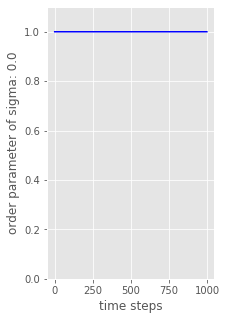

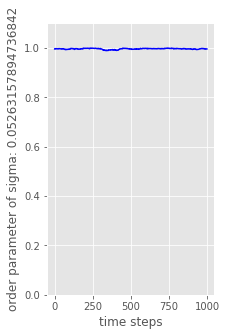

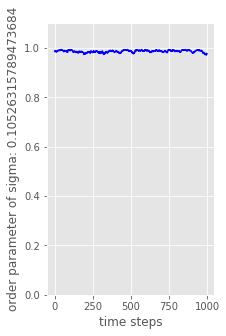

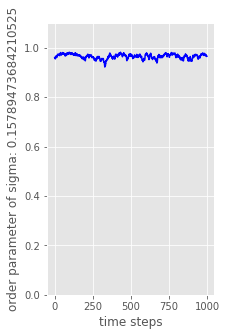

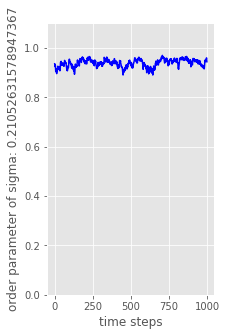

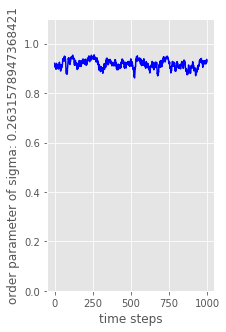

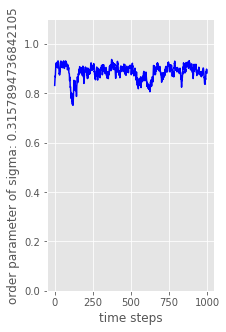

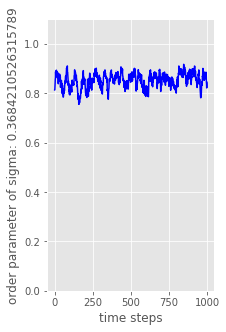

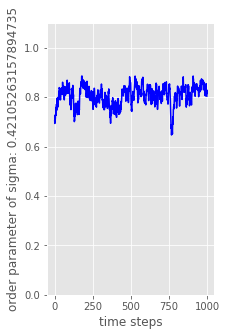

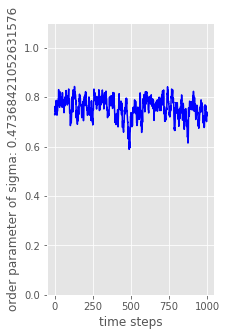

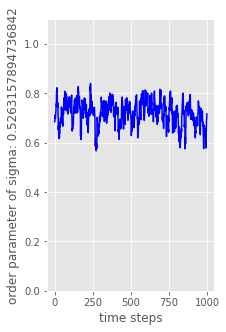

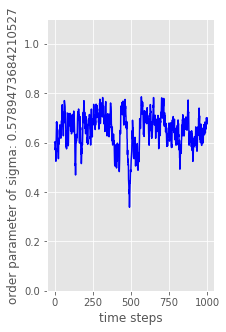

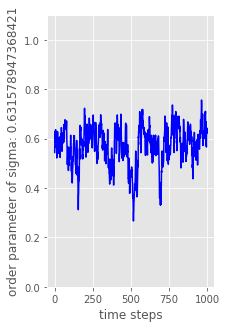

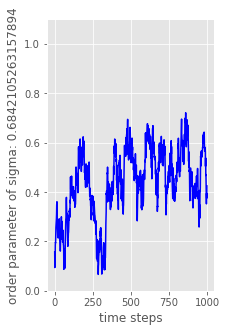

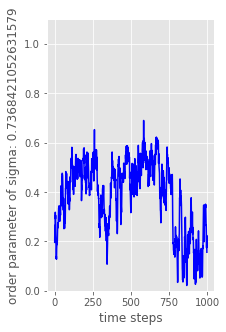

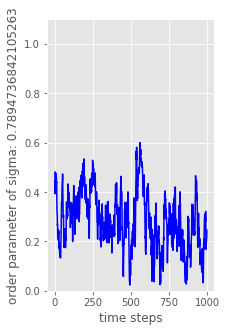

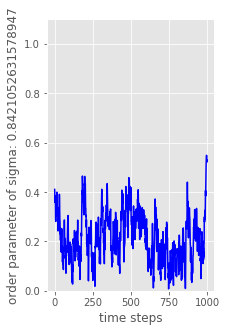

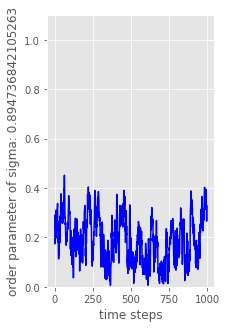

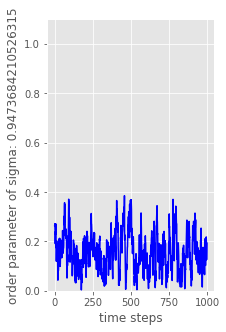

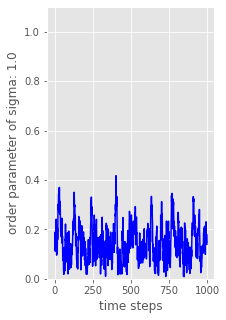

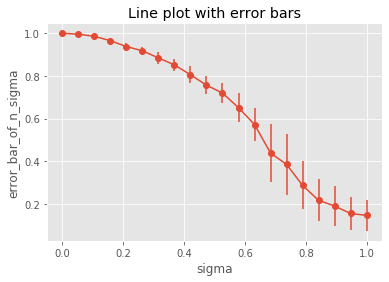

In [8]:
N = 200  # number of individual birds
L = 15   # size of the container(L*L)
v0 = 0.5  # the constant velocity of the birds per time step
R = 1 # radius within which to search for neighbours
T = 1000  # total time steps
n_sigma = 20  # number of sigma
sigma_array = np.linspace(0,1,n_sigma)
output = cal_n_sigma(L,N,v0,R,T,sigma_array)

fig, ax = plt.subplots()
ax.errorbar(sigma_array, output[:,0],yerr=output[:,1],fmt='-o')


ax.set_xlabel('sigma')
ax.set_ylabel('error_bar_of_n_sigma')
ax.set_title('Line plot with error bars')

plt.show()

# Part 6

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from scipy import stats
from scipy import spatial

# return the distance matrix(N*N) calculated from birds positions
def cal_pdist(pos,N,L):
    Dist = np.zeros((N,N))
    # calculate the distance between p1(ith bird) and p2(jth bird) under boundary conditions
    for i in range(1,N):
        for j in range(i):
            t1 = 0
            t2 = 0
            dx = pos[j,0] - pos[i,0]
            dy = pos[j,1] - pos[i,1]
            if dx > L/2:
                t1 = -L
            if dx < -L/2:
                t1 = L
            if dy > L/2:
                t2 = -L
            if dy < -L/2:
                t2 = L    
            Dist[i,j] = Dist[j,i] = np.sqrt((dx + t1)**2+(dy + t2)**2)
    return Dist


# initialize the state of birds and predator
def initialize(L,N,M):
    # prey
    prey = np.zeros((N,3))
    prey[:,:2] = np.random.uniform(0,L,(N,2)) # positions x,y
    prey[:,2] = np.random.uniform(0,2*np.pi,N) # angles theta
    # predator
    predator = np.zeros((M,3))
    predator[:,:2] = np.random.uniform(0,L,(M,2))  # positions x,y
    predator[:,2] = np.random.uniform(0,2*np.pi,M)  # angles theta
    return prey, predator

# update the state of birds and predator in each time step
def update(state, predator, L, v0, v_predator, R, R_predator, R_run_away, Noise_generator): 
    N = np.shape(state)[0]   # number of birds left
    M = np.shape(predator)[0]  # number of predators
        
    
    # Use adjacency matrix to determine neighbours
    birds = np.concatenate((state,predator),axis=0)
    A = cal_pdist(birds[:,:2],N+M,L)

    I = np.argmin(A[N:,:N],axis=1)  # the index of the bird nearest to the predator
    D = np.amin(A[N:,:N],axis=1)
    dead_bird_index = np.unique(I[D<(0.1)])
    
    state = np.delete(state, dead_bird_index, axis=0)  # delete the dead bird
    A = np.delete(A, dead_bird_index, axis=0)
    A = np.delete(A, dead_bird_index, axis=1)
    N = N-len(dead_bird_index)   # number of birds left decrease by 1     
    
    # Initialise heading
    heading = np.zeros(N)
    
    for i in range(N):
        adj = np.where(A[i,:N] < R)[0] # indices of adjacent particles
        theta = state[adj,2] # angles of all adjacent particles
        
        # Sum sin and cos of angles
        sum_sin = np.sum(np.sin(theta))
        sum_cos = np.sum(np.cos(theta))
        
        # Compute heading for this particle
        heading[i] = np.arctan2(sum_sin, sum_cos)
        
        adj = np.where(A[i,N:] < R_run_away)[0]
        if len(adj) > 0:
            dx = predator[adj,0] - state[i,0]
            dy = predator[adj,1] - state[i,1]
            dx[dx > L/2] -= L
            dx[dx < -L/2] += L
            dy[dy > L/2] -= L
            dy[dy < -L/2] += L  
            dist = np.sqrt(dx**2 + dy**2)
            run_away_angle = np.arctan2(-dy,-dx)
            sum_sin = np.sum(-np.log(dist/R_run_away)*np.sin(run_away_angle)) + np.sin(heading[i])
            sum_cos = np.sum(-np.log(dist/R_run_away)*np.cos(run_away_angle)) + np.cos(heading[i])
            heading[i] = np.arctan2(sum_sin, sum_cos)
                 
    for j in range(M):
        adj = np.where(A[N+j,:N] < R_predator)[0]
        if len(adj) > 0:
            dx = predator[j,0] - state[adj,0]
            dy = predator[j,1] - state[adj,1]
            dx[dx > L/2] -= L
            dx[dx < -L/2] += L
            dy[dy > L/2] -= L
            dy[dy < -L/2] += L  
            dist = np.sqrt(dx**2 + dy**2)
            run_after_angle = np.arctan2(-dy,-dx)
            sum_sin = np.sum(-np.log(dist/R_predator)*np.sin(run_after_angle))
            sum_cos = np.sum(-np.log(dist/R_predator)*np.cos(run_after_angle))
            predator[j,2] = np.arctan2(sum_sin, sum_cos) + Noise_generator.rvs(1) 
            # Update predator positions(mod L)
            predator[j,0] = (predator[j,0] + v_predator*np.cos(predator[j,2]))%L
            predator[j,1] = (predator[j,1] + v_predator*np.sin(predator[j,2]))%L
        else:
            predator[j,2] += Noise_generator.rvs(1) 
            # Update predator positions(mod L)
            predator[j,0] = (predator[j,0] + v0*np.cos(predator[j,2]))%L
            predator[j,1] = (predator[j,1] + v0*np.sin(predator[j,2]))%L
    
    # Update state with new headings
    state[:,2] = heading + Noise_generator.rvs(N)
    # Update positions(mod L)
    state[:,0] = (state[:,0] + v0*np.cos(state[:,2]))%L
    state[:,1] = (state[:,1] + v0*np.sin(state[:,2]))%L
    
    return state, predator

In [ ]:
N = 200  # number of preys
M = 3  # number of predators
L = 15   # size of the container(L*L)
v0 = 0.5  # the constant velocity of the birds per time step
v_predator = 0.6 # the constant velocity of the preditor per time step
R = 1 # radius within which to search for neighbours
R_predator = 3.5 # radius within which to catch the preys
R_run_away = R_predator # radius within which the prey spot the predator and try to run away
sigma = 0.01  # variance of noise
T = 300  # total time steps
Noise_generator = stats.norm(0,sigma)
opara = np.zeros(T) # the Vicsek order parameter

state, predator = initialize(L,N,M)
for t in range(T):
    state, predator = update(state, predator, L, v0, v_predator, R, R_predator, R_run_away, Noise_generator)
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.quiver(state[:,0],state[:,1],np.cos(state[:,2]),np.sin(state[:,2]),color='k') 
    ax.quiver(predator[:,0],predator[:,1],np.cos(predator[:,2]),np.sin(predator[:,2]),color='r')
    ax.set_xlim(0,15)
    ax.set_ylim(0,15)
    fig.savefig('pics/{}.png'.format(t))
    plt.close(fig)


In [ ]:
# make a video
import cv2
import numpy as np

T = 300
img_array = []
for i in range(T):
    #img = cv2.imread(filename)
    img = cv2.imread('pics/{}.png'.format(i))
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

 
 
out = cv2.VideoWriter('eat.mp4',cv2.VideoWriter_fourcc(*'FMP4'), 10, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()